# Using Logistic Regression and Decison Tree Classifier to Predict a Person's Income Level 



### 1. Introduction ###


Individual income is dependent on many factors. The most obvious are probably age, education level and occupation. The more subtle ones could include work classification and marital status. In this project, the objective is to train a model that predicts (based on given factors) whether a person earns over 50k USD / year or no. As such, the people can be separated into two groups based on their income: high earning and low earning. A potential application of such classification would be to prevent tax fraud - to notice when people deliberately lower their reported income. Another interesting application would be for companies to determine the wealth level of potential customers and optimize their product offerings that way.

The next section will formulate our interest as a machine learning problem that we can work with. After that, section 3 will describe the dataset and the method that we use to learn individual predictor maps. As we move further, section 4 will examine the results and compare different hypotheses. The final section 5 will serve as a conclusion, summarizing the results and outlining avenues for future work.

### 2. Problem Formulation ###


In this classification problem, the data points represent people. Each person has multiple characteristics that will be used as features, including age, race, sex, education, and so on. The complete list of features will be discussed in the next section. The individual's income level will be used as the label - that is the information that we want to predict. In this case, the label is binary: 1 if the person's annual income is >50k USD, and 0 if <= 50k USD.

As we will see, the dataset used in this project is imbalanced, which means that different classes occur with significantly different frequencies. Therefore, the quality of the model will be measured using a balanced accuracy score. Compared to the normal accuracy score (total number of correctly classified instances divided by total number of instances), the balanced one specifically avoids inflated performance estimates on imbalanced datasets. However, just as in the normal accuracy score, the higher the balanced accuracy score, the better the model. In binary case, it is calculated using the following formula:

\begin{equation}
BalancedAccuracy = \frac{1}{2} \big(\frac{TP}{TP + FN} + \frac{TN}{TN + FP}\big)\newline{}
\end{equation}

In a binary classification problem, where 1 is the positive label and 0 is the negative label, TP refers to correctly predicted positive label, FN to incorrectly predicted positive label, TN to correctly predicted negative label, and FP to incorrectly predicted negative label. In essence, balanced accuracy calculated by weighting the normal accuracy score of each label according to the inverse prevalence in the dataset.

### 3. Methods ###


The dataset used in this project was downloaded from https://www.openml.org/d/1590, which hosts a public database of datasets about various topics. In this case the dataset contains 48842 datapoints, 14 features for each datapoint, and the label vector. Here is the overview of the raw dataset:

In [1]:
import numpy as np 
import pandas as pd
import time
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn import datasets
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score

# Set random seed for reproducibility
np.random.seed(0)

df = pd.read_csv("OriginalDataset.csv")
display(df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


As we can see, the last column contains the labels, ie. whether a person earns more or less than 50k USD / year. Now, since this is a raw dataset, it requires quite a lot of pre-processing:

1. Some datapoints are missing features; those are marked with a question mark. In some situations, the absence of data might already hold valuable information, but arguably that is not the case here. For example, if a person is missing a race, it does not help in predicting the income. Therefore, a decision was made to delete all data points that are missing one or more features.


2. All people whose native-country is not the United States were dropped from the dataset, because the vast majority of the people have their native country as the US. Therefore, it was best to restrict the problem to those datapoints to find the most reliable predictor.


3. Three features were dropped completely: fnlwgt, education and native-country. Fnlwgt represents some unknown feature with no explanation (presumably related to some "final weight"). Since its purpose was unclear, it was dropped. Education feature was dropped because there is already another feature, education-num, which represents the education level as a numeric value (higher number refers to longer education). Native-country was dropped because after the filtering in step (2), all data points had the same value. Thus, it made sense to drop it completely.


4. Labels were replaced by numeric values: 1 if >50k, 0 if <= 50k. Sex was also replaced by numeric values: 1 if male, 0 if female. The main reason for replacing string values with numeric ones is because of Scikit-Learn package that was used. The decision trees implemented in Scikit-Learn use only numerical features and these features are interpreted always as continuous numeric variables. Therefore, it is important to realize that replacing strings with numbers induces an order within those features that may or may not exist in reality. It was a natural choice to order education level by numbers. It was also reasonable to order men and women, because there is an income gap in the United States.


5. All the rest non-numeric categorical features in the data cannot be simply ordered. For example, there is no realistic order between different marital statuses. Thus, work classification, marital status, occupation, relationship, and race were each encoded into multiple binary features using "one-hot-encoding" method. In essence, it splits one feature into multiple features, each of which represents a distinct category in the original feature. Then, a binary value 1 or 0 is assigned to each new feature depending on whether a datapoint belongs to that category.


Below is a histogram of native country of all people in the dataset, as well as the final dataset after all pre-processing was done.

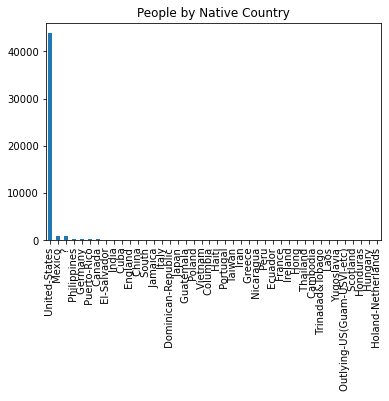

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,class,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,...,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,25,7,1,0,0,40,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,38,9,1,0,0,50,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,28,12,1,0,0,40,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,44,10,1,7688,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,34,6,1,0,0,30,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,12,0,0,0,38,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
48838,40,9,1,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
48839,58,9,0,0,0,40,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
48840,22,9,1,0,0,20,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


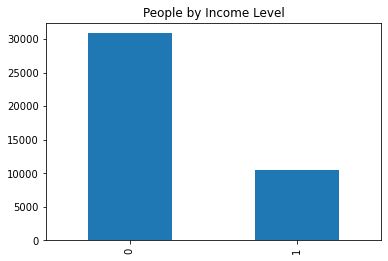

In [2]:
# A histogram showing number of people by native country
df["native-country"].value_counts().plot(kind = "bar", title = "People by Native Country")
plt.show()

# Dropping unnecessary features
df.drop(["fnlwgt", "education"], axis = 1, inplace = True)

# Deleting data points with missing values
for i in df.columns:
    df = df[df[i] != " ?"]

# Deleting non-US entries
df = df[df["native-country"] == " United-States"]

# Dropping the column, as now all datapoints have the same value for this feature
df.drop(["native-country"], axis = 1, inplace = True)

# Replacing strings with numerical values
df = df.replace([" Male", " Female"], [1, 0])
df = df.replace([" >50K", " <=50K"], [1, 0])

# Converting non-numeric features to (numeric) dummy features
df = pd.get_dummies(df)

display(df)

# A histogram showing the frequency of labels
df["class"].value_counts().plot(kind = "bar", title = "People by Income Level")
plt.show()

As we can see, the one-hot-encoding increased the number of features by over threefold. The final dataset has 41292 data points and 46 features. Moreover, from the last histogram we can see that the number of people in the low-income class is nearly three times larger than those in the high income class. That is the reason for using balanced accuracy score.

This final dataset will be split into three parts: the training set, the validation set and the test set with the ratio 70/20/10%. The datapoints in each split will be chosen at random; however, in order to have reproducible results, the project uses a fixed seed. The training set will be used to find the optimal parameters in each model. Then, the model will be validated using a single set of labeled data – the validation set. Validation means evaluating the predictive capability of a ML model on new data points. In the end, the performance of the final chosen model will be measured using the test set.

In [3]:
# Extract feature matrix and label vector from dataframe
y = df.iloc[:, 6:7].to_numpy().reshape(-1)
df.drop(["class"], axis = 1, inplace = True)
X = df.to_numpy()

# Split data into model selection and test sets
# Random_state: allows reproducible output
# Stratify: creates splits by preserving the same percentage for each target class as in the complete set
X_select, X_test, y_select, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True, stratify = y, random_state = 0)

# Split model selection data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_select, y_select, test_size = 0.222, shuffle = True, stratify = y_select, random_state = 0)

print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Training set: (28912, 45)
Validation set: (8250, 45)
Test set: (4130, 45)


Now, let us review and train two classification models: decision tree classifier and logistic regression. Between these two, the model that performs better will be chosen as the final model.

A decision tree is a flowchart-like representation of a predictor function $h(\mathbf{x})$ that reads in the features $\mathbf{x}$ of a data point and outputs a predicted label $\hat{y}=h(\mathbf{x})$. The decision tree goes through all features and performs a different test on each of them - for example "is the age of a person less than 20?". Each of these tests that leads to different outcomes is called a node. The nodes are connected by branches that correspond to the result of a test (there is one outgoing branch for each possible answer of a test node). At each "sub-node", there is another test, and so on. After the data point goes through all these nodes, it will end up at a "leaf node", which finally outputs the predicted label.

Optimization of a decision tree involves searching over a discrete set of different configurations of test nodes. In this project, I will be using a ready-made implementation of a decision tree classifier provided by a Scikit-Learn package. The loss function used to measure the quality of each split (at each node) will be based on information gain, which measures the reduction in entropy or surprise. The larger the information gain, the better the split.

The code below trains a decision tree classifier on the training dataset and outputs the training and validation error. To get a validation error, the trained model will predict the labels for data points in the validation set. A lower error indicates better performance. However, the chosen performance indicator of for models (balanced accuracy score) works the other way around. An accuracy score of 1 would indicate that the predictor function predicts with a 100% accuracy; therefore, the closer the accuracy score is to 1, the lower the error is. In order to make the error values intuitive, the accuracy score will be subtracted from one. The error can be then thought of as a percentage error, where 0 indicates a perfect model, while a model with an error of 1 predicts every label incorrectly.

In addition, performance of the predictor function on the validation set is visualized using a confusion matrix. It is a matrix of shape `(n_labels, n_labels)`. Each row represents the true label, and each column represents the predicted label. Using a confusion matrix, it is possible to analyze the classifier's performance for each possible value of the true label. This also means that the confusion matrix will show whether the classifier performs particularly well or poorly on some specific classes. A normalized confusion matrices displays the ratio of correctly or incorrectly predicted labels for each label. 

0.8173333333333334
45
1
[1.85316323e-01 1.25522552e-01 1.05489083e-02 1.20903302e-01
 4.25739262e-02 1.02990075e-01 7.23844390e-03 9.91007920e-03
 1.44455445e-02 7.74551508e-03 1.06130203e-02 6.50494287e-03
 2.32960421e-04 4.46038384e-03 1.53278883e-03 2.12856245e-01
 7.75896033e-04 2.79897214e-03 2.28823788e-03 1.78512154e-03
 8.84916157e-03 8.44504748e-05 1.02327279e-02 9.45727121e-03
 5.73936981e-03 2.97018398e-03 5.09100612e-03 6.53874118e-03
 0.00000000e+00 1.01875308e-02 4.07996334e-03 1.13339278e-02
 5.13849437e-03 8.20954428e-03 3.84671023e-03 4.11769737e-03
 1.92881956e-03 3.35776183e-03 2.65227047e-03 4.10611603e-03
 1.20929275e-03 1.91745335e-03 6.33843298e-03 7.18620550e-04
 1.08512139e-02]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
6163
2087
6234
2016
Training error: 0.0483655393122534
Validation error: 0.2472781637888628


/opt/software/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/software/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


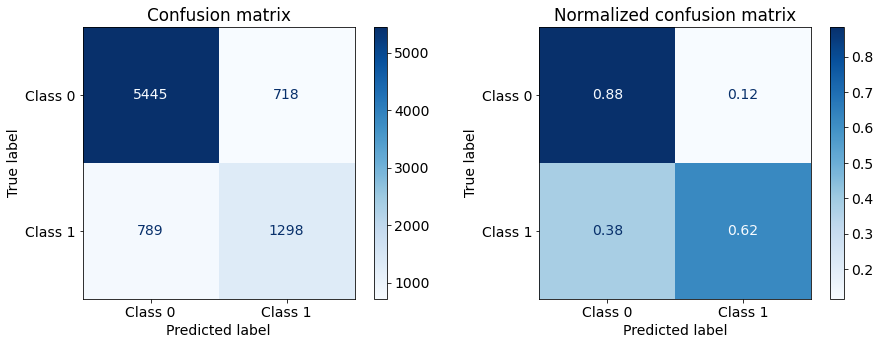

In [6]:
# Training a decision tree with the loss function described above
dtc = DecisionTreeClassifier(criterion = "entropy")
dtc.fit(X_train, y_train)
y_predTrain = dtc.predict(X_train)
y_predVal = dtc.predict(X_val)

# Calculating balanced accyracy scores
balErrTrain = balanced_accuracy_score(y_train, y_predTrain)
balErrVal = balanced_accuracy_score(y_val, y_predVal)

print(dtc.score(X_val, y_val))

print(dtc.n_features_in_)
print(dtc.n_outputs_)
print(dtc.feature_importances_)

print(y_val)
print(y_predVal)
print(np.count_nonzero(y_val == 0))
print(np.count_nonzero(y_val == 1))
print(np.count_nonzero(y_predVal == 0))
print(np.count_nonzero(y_predVal == 1))

print(f"Training error: {1 - balErrTrain}")
print(f"Validation error: {1 - balErrVal}")

# Defining a function to easily plot confusion matrices
def plotConfMatrix(classifier, xData, yData):
    classes = ["Class 0", "Class 1"]
    options = [("Confusion matrix", None, 0),
               ("Normalized confusion matrix", "true", 1)]
    
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    plt.rc('font', size = 14)
    for title, normalize, ax_idx in options:
        disp = plot_confusion_matrix(classifier, xData, yData,
                                     display_labels = classes,
                                     cmap = plt.cm.Blues,
                                     normalize = normalize, ax = axes[ax_idx])
        disp.ax_.set_title(title)

    plt.show()

plotConfMatrix(dtc, X_val, y_val)

The training error is clearly very low: 4.8%. In fact, a decision tree classifier is often perfect on the training data. The slight error here might be due to the fact that a few data points with highly similar features that ended up on the same leaf node had different labels. On the other hand, the validation error is significantly larger: 24.6%. The training error is overestimating the performance of the model, which is referred to as overfitting. Indeed, we can see that the predictor does not generalize really well on new data.

An interesting observation from the results is that the prediction accuracy is higher for the class 0 (annual earnings <= 50k USD), as seen from the confusion matrix. A likely explanation for this is that the dataset was imbalanced, and hence the model learned a better predictor for the class that occurred more frequently. Now, let us move to the logistic regression.

Logistic regression is a classification algorithm that uses a linear function to classify data points into distinct categories. This means that a basic assumption in logistic regression is that there is a linear relationship between the features and the basis for assigning the label. The predictor function in logistic regression is of the following form:

\begin{equation}
 f(x) = \begin{cases} 1 & \mbox{ for } w_0 + \mathbf{w}^T\mathbf{x} \geq 0 \\ 0 & \mbox{ for } w_0 + \mathbf{w}^T\mathbf{x} < 0 \end{cases}
 \tag{4}
\end{equation}

Here $\mathbf{x}$ is the vector representing the _n_ features of a data point, $\mathbf{w}$ a vector of all weights (coefficients) $w_1, . . . ,w_n$, and $w_0$ is the intercept. It is important to note that logistic regression does not assume that the label $y$ of a data point is deterministically defined by the features $\mathbf{x}$. Rather, it is a probabilistic model where it is assumed that the features $x$ are related to the probabilities (log-odds) of the data point having the different labels. The further away $w_0 + \mathbf{w}^T\mathbf{x}$ is from zero, the higher the probability that the data point belongs to either class 1 or 0.

A logistic regression model is fitted by minimizing the average logistic loss with respect to $w_0$ and $\mathbf{w}$. For a single data point (with features $\mathbf{x}$ and label $y$), the logistic loss is defined as

\begin{equation}
    -y \ln \big(\sigma(w_0 + \mathbf{w}^{T}\mathbf{x})\big)-(1-y)\ln\big(1-\sigma(w_0 + \mathbf{w}^{T}\mathbf{x})\big)
\end{equation}

where $\sigma(\mathbf{z})$ is the sigmoid function

\begin{equation}
\sigma(\mathbf{z}) = \frac{1}{1 + \exp{(\mathbf{-z})}}
\end{equation}

Since the features in the dataset are of very different scales, it is best to standardize the dataset. Otherwise, the iterative optimization algorithms used for training the logistic regression model will take a lot of time - or in the worst scenario, they might fail completely. Standardizing is done for each feature value by subtracting the feature mean from it and dividing by the standard deviation ($\sigma$) of the feature:

\begin{equation}
    \mathbf{z}_j^{(i)} = \frac{\mathbf{x}_j^{(i)} - \bar{\mathbf{x}}}{\sigma(\mathbf{x})}
\end{equation}

This transformation makes 0 the mean of each feature, and the new values of the feature represent the deviation from the feature mean as measured by the number of standard deviations (+/-). With this in mind, the following code trains a logistic regression classifier on the standardized training dataset.

0.8396363636363636
[0 1]
[[ 0.33885646  0.69329398  0.34069246  2.51163604  0.25762338  0.35326405
   0.11226997 -0.0163988   0.0466732   0.04013735 -0.12174682 -0.04561428
  -0.01825651 -0.29191702  0.06441905  0.87535915 -0.08325764 -0.59598556
  -0.15057351 -0.13814578 -0.01357505  0.00529372 -0.0059495   0.25234488
  -0.1817407  -0.14241261 -0.0917809  -0.27145942 -0.25421923  0.1638197
   0.07035097  0.07860245  0.09026965 -0.02990534 -0.13120324  0.2261235
  -0.11053426 -0.24168322  0.11344606  0.1627539  -0.06051213  0.04133377
  -0.01637523 -0.01412448  0.02401819]]
[-1.91062784]
45
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 1 0]
6163
2087
6520
1730
Training error: 0.22798632494870008
Validation error: 0.24043126900484446


/opt/software/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/software/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


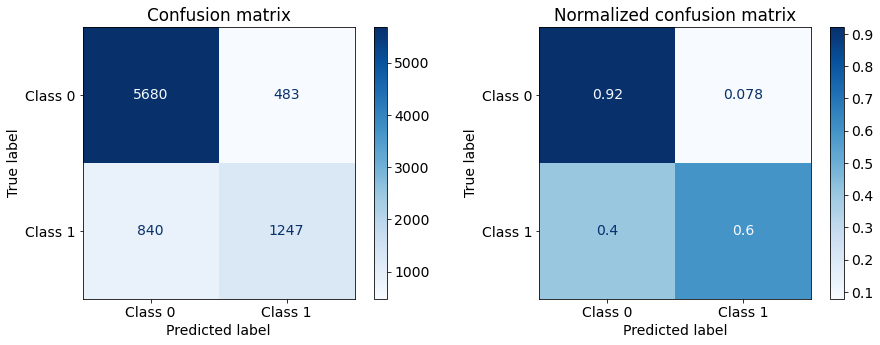

In [5]:
# Logistic regression with standardization
ss = StandardScaler()
# A large value for parameter C gives a linear regression model that is not regularized
lr = LogisticRegression(C = 1e6)
pipe = Pipeline([("scaler", ss), ("log_reg", lr)])
pipe.fit(X_train, y_train)

y_predTrain = pipe.predict(X_train)
y_predVal = pipe.predict(X_val)

print(pipe.score(X_val, y_val))

print(lr.classes_)
print(lr.coef_)
print(lr.intercept_)
print(lr.n_features_in_)

print(y_val)
print(y_predVal)
print(np.count_nonzero(y_val == 0))
print(np.count_nonzero(y_val == 1))
print(np.count_nonzero(y_predVal == 0))
print(np.count_nonzero(y_predVal == 1))

balErrTrain = balanced_accuracy_score(y_train, y_predTrain)
balErrVal = balanced_accuracy_score(y_val, y_predVal)

print(f"Training error: {1 - balErrTrain}")
print(f"Validation error: {1 - balErrVal}")

plotConfMatrix(pipe, X_val, y_val)

Compared to the decision tree classifier, the logistic regression outputs a significantly larger training error: 23.3%. However, the validation error is much closer to the training error, which means that unlike the decision tree classifier, this model is not significantly overfitting. In fact, it is even underfitting a little, as the validation error is 22.4% - almost one percentage point lower than the training error. This is a somewhat unusual case (usually the models overfit), which could be resulted from this particular validation set split. Similarly to the decision tree classifier, the logistic regression model also has a better prediction accuracy for class 0.

When comparing these two models we select the one with the smallest validation error, which is the logistic regression. Now that the best model is found, we can move on to discuss the results.

### 4. Results ###

To test the performance of the chosen logistic regression model, we will use the test set, which had 10% of the original data points, and which was not used for neither training nor validation.

Test error: 0.22868021682318362


/opt/software/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/software/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


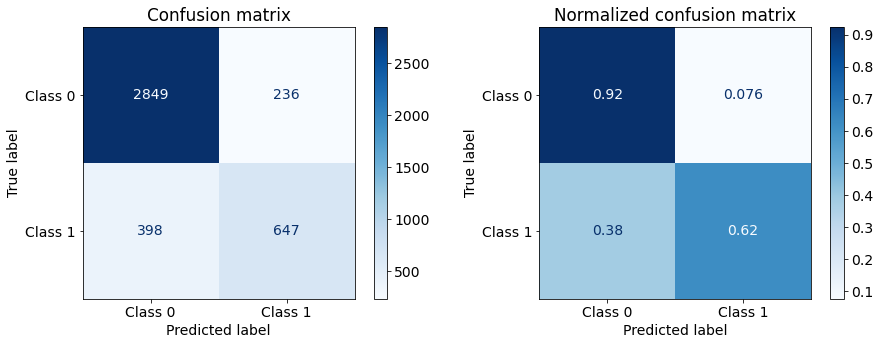

Balanced accuracy score: 0.7713197831768164


In [6]:
y_predTest = pipe.predict(X_test)

balErrTest = balanced_accuracy_score(y_test, y_predTest)

print(f"Test error: {1 - balErrTest}")

plotConfMatrix(pipe, X_test, y_test)

print(f"Balanced accuracy score: {balErrTest}")

The test error (23.0%) is a little higher than the validation error (22.4%), but still a little lower than the training error (23.3%). Based on the test set results, the model generalizes well on the new data - with similar accuracy that it had during training. The model performs quite well when predicting class 0, where it has an accuracy score of 93%. However, the accuracy score for class 1 is much lower - only 38%. This means that the predictor gets well over half predictions wrong for class 1. The balanced accuracy score of the model is 77.0%. 

### 5. Conclusion ###

We have studied two models - a decision tree and a logistic regression - to learn a hypothesis that classifies a person in two groups based on his/her income. The validation errors were calculated using single set of labeled data, after which the models were compared against each other based on those errors. The logistic regression showed a slightly better performance of approximately 2 percentage points, so it was chosen as the final model. Its balanced accuracy score is 77.0%.

By itself, the accuracy score does not tell us whether the model performance is satisfactory. Therefore, it is useful to benchmark the score against other scores that are available on https://www.openml.org/t/7592. The best predictive accuracy on the website is approximately 88%, which means that the final model found in this project has quite a lot of room for improvement. 

One way to try improving the logistic regression model could be to use regularization (the parameter "C" in the model). As for the decision tree classifier, some different hyperparameters could have been tested, such as the "gini" loss function instead of "entropy", to obtain a predictor that generalizes better. Then, some additional feature engineering could potentially lead to better results. For example, another model could be trained without features that are considered redundant. Another way of improving the project would have been to use a K-fold cross validation instead of a single split validation. It would not directly improve the model performance, but it would give more precise estimates for training and validation errors.

It is important to note that the dataset is not "perfect" either. It does not have an exhaustive list of all features that can be used for income level prediction. There are other significant factors as well, such as university ranking (e.g. Harvard vs 2-year community college), city and state of residence, and so on. With such features, the accuracy of the best predictor could potentially be increased above the 88% benchmark performance.

In addition to improving the current classifier model, one interesting avenue for future work could be a multiclass classification. Instead of splitting the income levels in above or below 50k USD / year, more precise classes could be created, such as 0-10k, 10-20k, 30-40k, etc. This would most likely require more data points and features, though, to get to the similar accuracy level as with this binary classification.